In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 

In [3]:
def loadData(file):
    return np.load(file)['image'], np.load(file)['label']

In [4]:
def norm(data):
    return data / 255

In [5]:
def oneHotEncoding(array):
    init = array.astype(int)
    n_classes = int(np.max(init)) + 1 #總共有幾個種類的label
    return np.eye(n_classes)[init]

In [6]:
# load data
train_X , train_y = loadData("../train.npz")
test_X, test_y = loadData("../test.npz")

In [7]:
# image data normalization
train_X = norm(train_X)
test_X = norm(test_X)

In [8]:
# reshape image data  
train_X = train_X.reshape((train_X.shape[0],-1))
test_X = test_X.reshape((test_X.shape[0],-1))

In [9]:
# one hot encoding
train_y = oneHotEncoding(train_y)
test_y = oneHotEncoding(test_y)

In [10]:
# transpose the matrix 
# 以符合 z = wx+b 計算所需要的維度
train_X = train_X.T
test_X = test_X.T
train_y = train_y.T
test_y = test_y.T

In [11]:
# activation function: sigmoid
def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def Softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

# compute multi-class loss
def computeLoss(y, y_output):
    lossSum = np.sum(np.multiply(y, np.log(y_output)))
    m = y.shape[1]
    loss = -(1/m)*lossSum
    return loss

In [12]:
# minibatch
def minibatch(X,Y):
    
    batchNum = dataAmt//batchSize
    
    if dataAmt%batchSize != 0:
        fillCount = dataAmt - batchNum*batchSize # 要補幾個0*784
        X = np.append(X ,np.zeros((imgSize, fillCount)), axis=1)
        Y = np.append(Y ,np.zeros((imgClasses, fillCount)), axis=1)
        batchNum = batchNum + 1
        
    X = X.reshape((X.shape[0], batchSize, batchNum))
    Y = Y.reshape((Y.shape[0], batchSize, batchNum))
    
    return X,Y

In [13]:
X = train_X
Y = train_y

imgSize = X.shape[0] 
imgClasses = Y.shape[0]
dataAmt = X.shape[1]
train_X.shape, train_y.shape

((784, 12000), (10, 12000))

In [52]:
def forwardPass(x):
    a, z = [0]*layers, [0]*layers
    
    z[0] = np.matmul(w[0],x) + b[0]
    a[0] = Sigmoid(z[0])
    
    k = 1
    while layers > 2 and layers-k > 1:
        z[k] = np.matmul(w[k],a[k-1]) + b[k]
        a[k] = Sigmoid(z[k])
        k += 1
    
    z[-1] = np.matmul(w[-1],a[-2]) + b[-1]
    a[-1] = Softmax(z[-1])
    
    return z,a

In [53]:
def backwardPass(x,y):
    dz, da, dw, db = [0]*layers, [0]*layers, [0]*layers, [0]*layers
    m = y.shape[1]
    
    
    dz[-1] = a[-1] - y
    dw[-1] = (1. / m) * np.matmul(dz[-1], a[-2].T)
    db[-1] = (1. / m) * np.sum(dz[-1], axis=1, keepdims=True)
    
    k = layers-1
    while layers > 2 and k > 1:
        
        da[k-1] = np.matmul(w[k].T, dz[k])
        
        dz[k-1] = da[k-1] * Sigmoid(z[k-1]) * (1 - Sigmoid(z[k-1]))
        dw[k-1] = (1. / m) * np.matmul(dz[k-1], a[k-2].T)
        db[k-1] = (1. / m) * np.sum(dz[k-1], axis=1, keepdims=True)
        
        k -= 1
    
    da[0] = np.matmul(w[1].T, dz[1])
    dz[0] = da[0] * Sigmoid(z[0]) * (1 - Sigmoid(z[0]))
    dw[0] = (1. / m) * np.matmul(dz[0], x.T)
    db[0] = (1. / m) * np.sum(dz[0], axis=1, keepdims=True)
    
    return dz, da, dw, db

In [54]:
def update(lr,w,b,dw,db):
    for i in range(layers): 
        w[i] = w[i] - lr * dw[i]
        b[i] = b[i] - lr * db[i]
    return w, b

In [86]:
def accuracy(x,y):
    z1,a1 = forwardPass(x)
    real = np.argmax(y, axis=0)
    pred = np.argmax(a1[-1], axis=0)
    acc = 0
    for i in range(x.shape[1]):
        if real[i]==pred[i]:
            acc+=1
    return acc, acc/x.shape[1]

In [61]:
def initializeWB(initType='random'):
    initType = initType
    w, b = [0]*layers, [0]*layers
    
    if initType == 'random': # randomly initialize w
        w[0] = np.random.randn(hiddenDim[0], imgSize) #random
        b[0] = np.zeros((hiddenDim[0], 1))
        k = 1
        while layers > 2 and layers-k > 1:
            w[k] = np.random.randn(hiddenDim[k], hiddenDim[k-1]) #random
            b[k] = np.zeros((hiddenDim[k], 1))
            k += 1
        w[-1] = np.random.randn(Y.shape[0], hiddenDim[-1]) #random
        b[-1] = np.zeros((Y.shape[0], 1))
    
    else: # initialize w with zeros
        w[0] = np.zeros((hiddenDim[0], imgSize)) #zero
        b[0] = np.zeros((hiddenDim[0], 1))
        k = 1
        while layers > 2 and layers-k > 1:
            w[k] = np.zeros((hiddenDim[k], hiddenDim[k-1])) #zero
            b[k] = np.zeros((hiddenDim[k], 1))
            k += 1
        w[-1] = np.zeros((Y.shape[0], hiddenDim[-1])) #zero
        b[-1] = np.zeros((Y.shape[0], 1))
    
    return w,b

In [62]:
def plot(): # plot the loss, and training & testing acc and error rate
    err_train = np.ones((len(acc_train))) - acc_train
    err_test = np.ones((len(acc_test))) - acc_test
    
    plt.style.use("default")
    plt.figure(figsize=(6,4))
    plt.title("training acc")
    plt.plot(acc_train, color='b')
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.title("training error")
    plt.plot(err_train, color='b')
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.title("testing acc")
    plt.plot(acc_test, color='r')
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.title("testing error")
    plt.plot(err_test, color='r')
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.title("training loss")
    plt.plot(losses, color='g')
    plt.show()

In [87]:
# set up the network
batchSize = 32
layers = 3
hiddenDim = [20,15] #512,256

w,b = initializeWB(initType='random')
learningRate = 0.099 # 0.099
epochs = 10

# store loss and acc
losses = []
acc_train = []
acc_test = []

# latent record
latent_z = []
latent_trueAns = []

# for better performance
# count = 0
best_w = []
best_score = 0

In [88]:
for i in range(epochs):
    
    # shuffle data
    index = np.random.permutation(12000)
    train_X = train_X[:,index]
    train_y = train_y[:,index]
    
    # minibatch
    X,Y = minibatch(train_X,train_y)
    
    loss = 0
    
    for batch in range(X.shape[2]): # X.shape[2] = batch的數量
        X_batch = X[:,:,batch]
        Y_batch = Y[:,:,batch]
        
        # forward
        z,a = forwardPass(X_batch)
        
        # loss
        loss += computeLoss(Y_batch, a[-1])
        
        # backward
        dz, da, dw, db = backwardPass(X_batch,Y_batch)
        
        # update
        w, b = update(learningRate,w,b,dw,db)
    
    if i % 1000 == 0 and i != 0:
        learningRate /= 10
    
    # loss
    losses.append(loss/dataAmt)
    
    # train acc
    correct_train, score_train = accuracy(train_X,train_y)
    acc_train.append(score_train)
    
    if score_train > best_score:
        best_w = w
        best_score = score_train
    else:
#         count += 1
#         if count > 10:
#             print("Early Stopping because the accuracy didn't improve...")
#             break
        w = best_w
    
    # test acc
    correct_test, score_test = accuracy(test_X,test_y)
    acc_test.append(score_test)
    
    # latent
    if i % 10 ==0:
        _z, _a = forwardPass(test_X)
        _y = test_y
        latent_z.append(_z[-2])
        latent_trueAns.append(_y)
        
        print("Epoch:", i, "/", str(epochs), ",Loss:", loss/dataAmt)
        print("train score:",correct_train,"/",str(train_X.shape[1]),", train score:",score_train)
        print("test score:",correct_test,"/",str(test_X.shape[1]),", test score:",score_test)
        print("------------------------------------------------------------------------------------------------")

Epoch: 0 / 10 ,Loss: 0.06732805214716203
train score: 4932 / 12000 , train score: 0.411
test score: 2353 / 5768 , test score: 0.4079403606102635
------------------------------------------------------------------------------------------------


In [40]:
acc_train[-1], acc_test[-1], losses[-1]

(0.9630833333333333, 0.8932038834951457, 0.0040364594557712585)

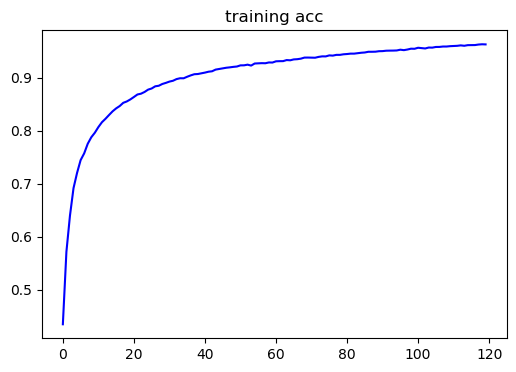

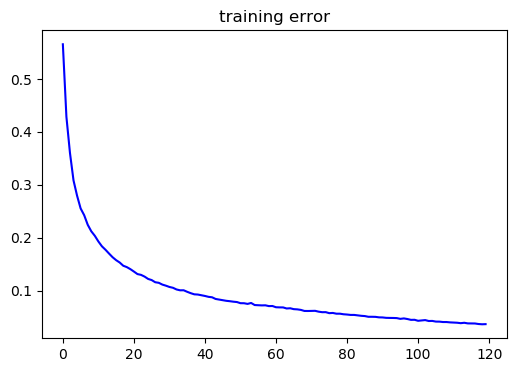

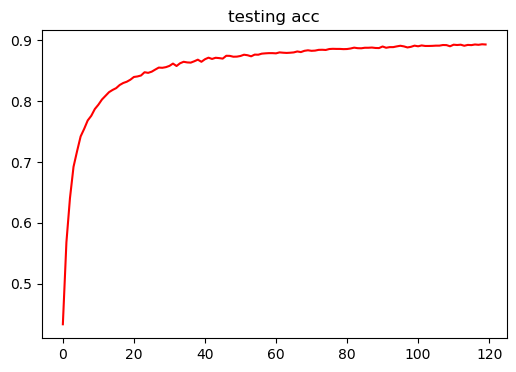

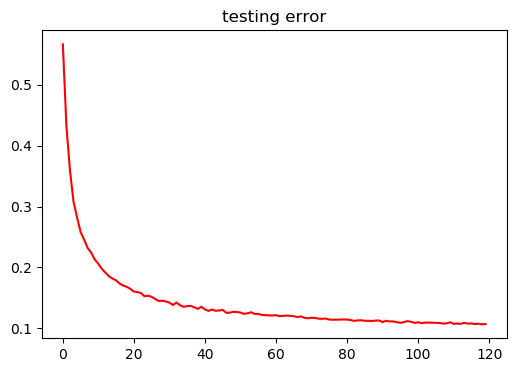

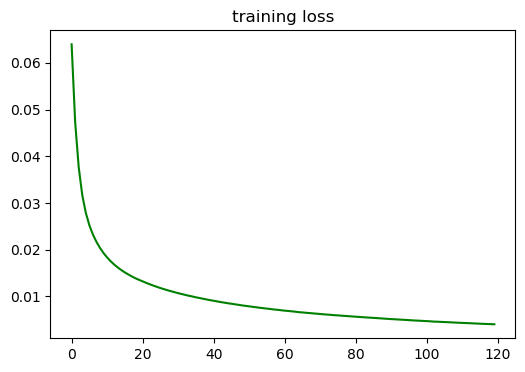

In [41]:
plot()

### Latent Features

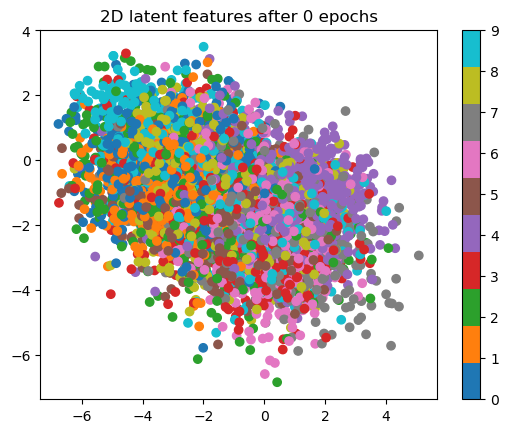

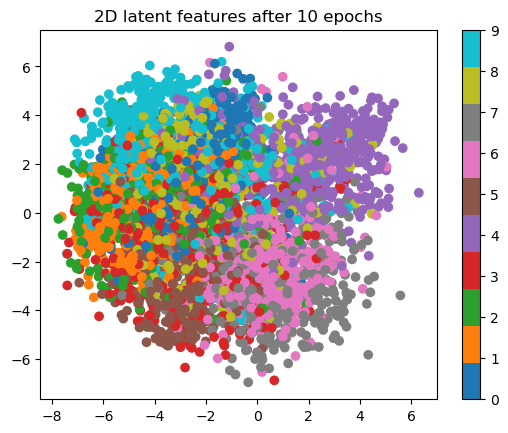

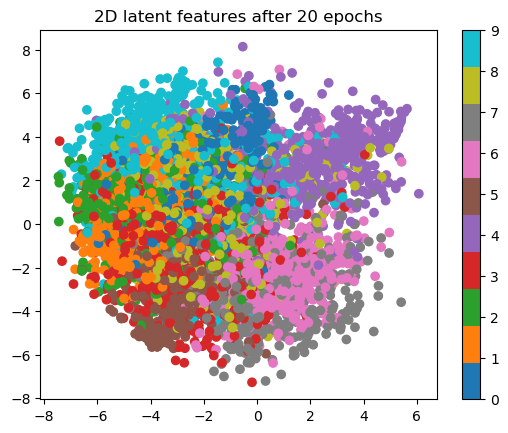

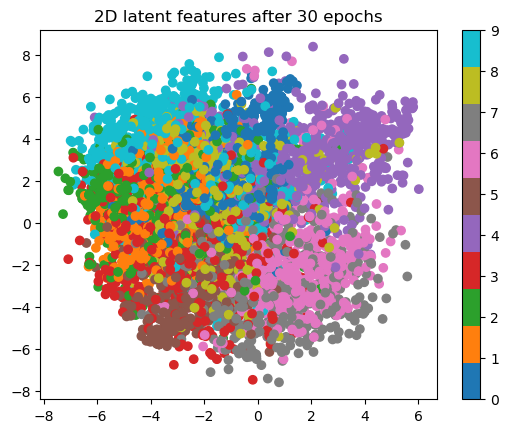

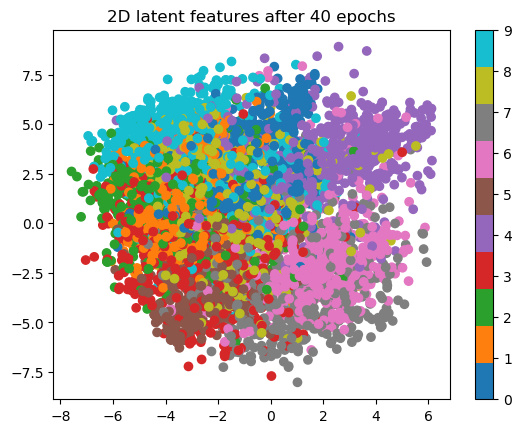

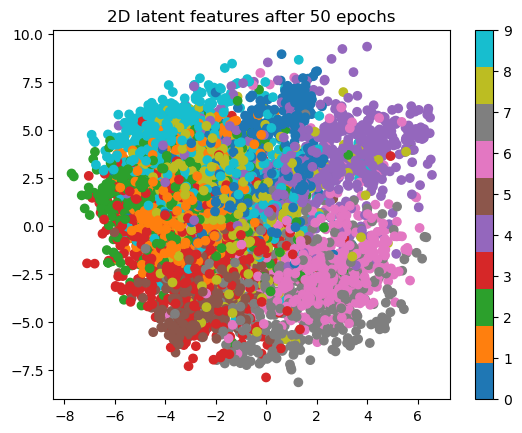

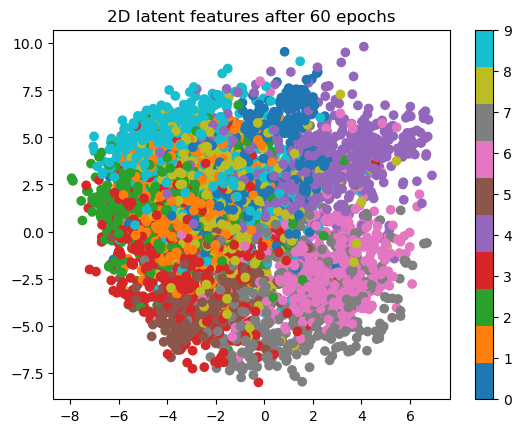

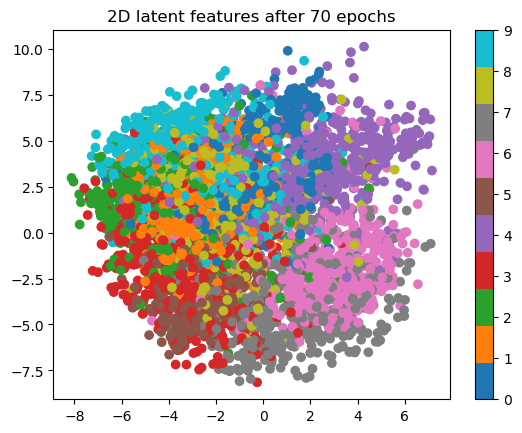

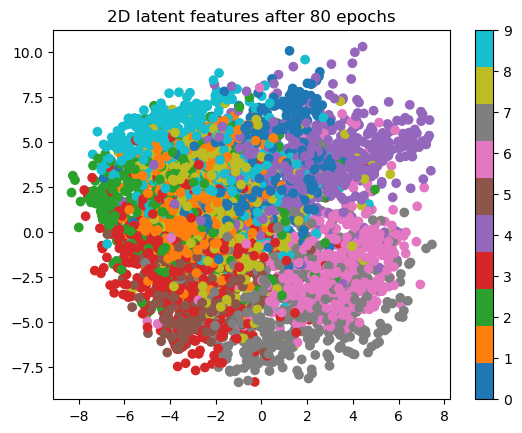

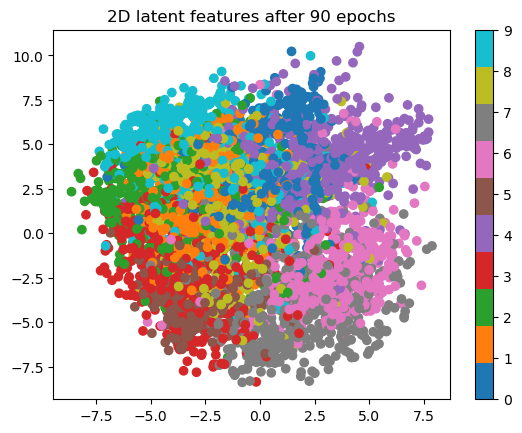

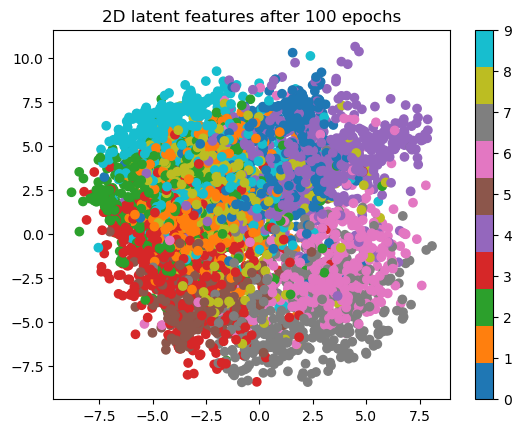

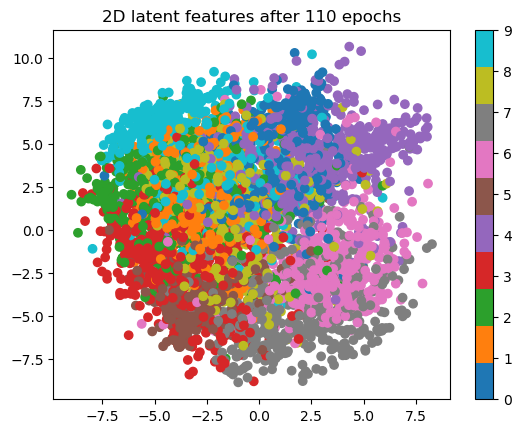

In [23]:
for i in range(len(latent_z)):
    plt.style.use("default")
    plt.title("2D latent features after "+ str(i*10)+ " epochs")
    plt.scatter(latent_z[i].T[:,0],latent_z[i].T[:,1], c=np.argmax(latent_trueAns, axis=1)[0], marker='o', cmap='tab10')# marker='.', cmap='tab10',
    plt.colorbar()
    plt.show()

In [ ]:
# 32,16,2
for i in range(len(latent_z)):
    plt.style.use("default")
    plt.title("2D latent features after "+ str(i*10)+ " epochs")
    plt.scatter(latent_z[i].T[:,0],latent_z[i].T[:,1], c=np.argmax(latent_trueAns, axis=1)[0], marker='o', cmap='tab10')# marker='.', cmap='tab10',
    plt.colorbar()
    plt.show()

In [ ]:
for i in range(len(latent_z)):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_z[i].T)
#     tsne = manifold.TSNE(n_components=2, init='pca')
#     tsne_result  = tsne.fit_transform(latent_z[i].T)
    
    plt.style.use("default")
    plt.title("2D latent features after "+ str(i*10)+ " epochs")
    
    plt.scatter(pca_result[:,0],pca_result[:,1], c=np.argmax(latent_trueAns, axis=1)[0], marker='o', cmap='tab10')# marker='.', cmap='tab10',
    plt.colorbar()
    plt.show()

In [ ]:
from sklearn import manifold
# tsne = manifold.TSNE(n_components=2, init='pca')
# X_tsne = tsne.fit_transform(X)

for i in range(len(latent_z)):
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(latent_z[i].T)
    tsne = manifold.TSNE(n_components=2, init='pca')
    tsne_result  = tsne.fit_transform(latent_z[i].T)
    # plot
    plt.style.use("default")
    plt.title("2D latent features after "+ str(i*10)+ " epochs")
    
    plt.scatter(tsne_result[:,0],tsne_result[:,1], c=np.argmax(latent_trueAns, axis=1)[0], marker='o', cmap='tab10')# marker='.', cmap='tab10',
    plt.colorbar()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
def confusionMatrixShow(x,y):
    z1,a1 = forwardPass(x)
    real = np.argmax(y, axis=0)
    pred = np.argmax(a1[-1], axis=0)
    return confusion_matrix(real,pred)

In [ ]:
confusionMatrixShow(train_X,train_y)

In [ ]:
confusionMatrixShow(test_X,test_y)

In [ ]:
cnt = 0
for i in range(len(test_X)):
    if real[i] != pred[i]:
        cnt += 1
        print(i,": ","true is ", real[i]," , pred is ", pred[i])
print(cnt)